In [1]:
import tequila as tq
from tequila.hamiltonian.paulis import X,Y,Z,I
import numpy as np
from numpy import random
import os 
from numpy import pi
from scipy.sparse import linalg as s_linalg

# Import graphical library for plots.
import matplotlib.pyplot as plt
import time

In [6]:
# Exact diagonalization
def Htrans_exact(ham):
    ham_matrix = ham.to_matrix()
    energ = np.linalg.eigvals(ham_matrix)
    return(min(energ).real)

### Single-qubit test case

In [4]:
n_qub = 1 # number of qubit

# Vertical gate blocks in the ansatz for easy referencing in the QIPA
Block0 = tq.gates.H(target=n_qub)+tq.gates.X(target=n_qub)
Block1 = tq.gates.Ry(target=0,angle=tq.Variable("th_0"))
Block2 = tq.gates.Rz(target=0,angle=tq.Variable("th_1"))
Block3 = tq.gates.Ry(target=0,angle=tq.Variable("th_2"))
Block4 = tq.gates.Rz(target=0,angle=tq.Variable("th_3"))

def testham1():
    ham = 15 + Z(0)
    return ham

def ansatz_test1():
    U = tq.QCircuit()
    U += Block1 + Block2
    return U

def ansatz_test1_qipa():
    U = tq.QCircuit()
    U += Block3 + Block4
    return U

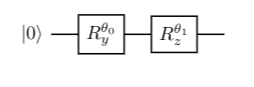

In [30]:
# single qubit ansatz

from IPython.display import Image

Image(filename=('single_qubit_ansatz.png'))

In [123]:
# QIPA with test Hamiltonian and ansatz circuit

In [8]:
def Y_ctrl():
    YC = tq.gates.Trotterized(generator=1-Y(0),angle=np.pi,target=0,control=n_qub)
    return YC

def Z_ctrl():
    ZC = tq.gates.Trotterized(generator=1-Z(0),angle=np.pi,target=0,control=n_qub)
    return ZC

def A_element_matrix(i,j,qipa_stat):
    A = []
    if (i<j):
        if (i<n_qub+1) and (j<n_qub+1):
            if qipa_stat == False:
                A = Block0 +  Y_ctrl() + tq.gates.X(target=n_qub) + Block1 + Z_ctrl() + Block2
            else:
                A = Block0 +  Y_ctrl() + tq.gates.X(target=n_qub) + Block3 + Z_ctrl() + Block4
    return A

def delta_step(var_values):
    # Constructing the matrix A

    f = 0.25 # (f^*_{ki}.f_{lj})
    A_matrix = np.zeros((len(var_values),len(var_values)))
    for i in range(len(A_matrix)):
        for j in range(len(A_matrix)):
            if (i<j):
                E = tq.ExpectationValue(H=X(n_qub), U=A_element_matrix(i,j,qipa_stat=False))
                A_matrix[i][j] += np.real(f*tq.simulate(E, variables=var_values))
            elif (i>j):
                A_matrix[i][j] += A_matrix[j][i]
            else:
                A_matrix[i][j] += 0.25
    
    # Constructing the vector C

    kappa = 1 # 1 for imaginary time, >1 for QIPA
    fC = 1j/2
    C_vec = np.zeros((len(var_values),1))
    total_U = ansatz_test1() 
    Ham = testham1()
    for i in range(len(C_vec)):
        E = tq.ExpectationValue(H=Ham, U=total_U)
        dE = tq.grad(E,"th_"+str(i))
        C_vec[i] += np.real(0.5*kappa*tq.simulate(dE, variables=var_values))
    
    # invoking conjugate gradient method rather than explictly inverting a matrix
    output = s_linalg.cg(A_matrix,C_vec,tol=1e-4)
    return -1.0*output[0]

def delta_step_qipa(b,tau,var_values):
    # Constructing the matrix A

    f = 0.25 # (f^*_{ki}.f_{lj})
    A_matrix = np.zeros((len(var_values),len(var_values)))
    for i in range(len(A_matrix)):
        for j in range(len(A_matrix)):
            if (i<j):
                E = tq.ExpectationValue(H=X(n_qub), U=A_element_matrix(i,j,qipa_stat=True))
                A_matrix[i][j] += np.real(f*tq.simulate(E, variables=var_values))
            elif (i>j):
                A_matrix[i][j] += A_matrix[j][i]
            else:
                A_matrix[i][j] += 0.25
    
    # Constructing the vector C
    fC = 1j/2
    C_vec = np.zeros((len(var_values),1)) 
    Ham = testham1()
    Ham_mod = Ham + (b*tau*Ham*Ham) + 0.5*b*b*tau*tau*(Ham**3)
    for i in range(len(C_vec)):
        E = tq.ExpectationValue(H=Ham_mod, U=ansatz_test1_qipa())
        dE = tq.grad(E,"th_"+str(i+len(C_vec)))
        C_vec[i] += np.real(0.5*b*tq.simulate(dE, variables=var_values))
    
    # invoking conjugate gradient method rather than explictly inverting a matrix
    output = s_linalg.cg(A_matrix,C_vec,tol=1e-4)
    return -1.0*output[0]

In [9]:
# QITE subroutine

# Random initialization of variables at t=0
pqc_var_values = {key: random.uniform(0, np.pi) for key in variables} # single qubit ansatz
# Copying the dictionary to another dict. with different keys
Obj_ext = tq.ExpectationValue(H=testham1(), U=ansatz_test1_qipa())
variables_ext = Obj_ext.extract_variables()
variables_ext = sorted(variables_ext, key=lambda x: x.name)
cnt = 0
temp_values = np.zeros(len(pqc_var_values))
for key,value in pqc_var_values.items():
    temp_values[cnt] = value
    cnt +=1
cnt = 0
stored_values = dict(zip(variables_ext, [None]*len(variables_ext)))
for k in stored_values:
    stored_values[k] = temp_values[cnt]
    cnt += 1
        
E = tq.ExpectationValue(H=testham1(), U=ansatz_test1())
res = tq.simulate(E, variables=pqc_var_values)

Energy_qite = np.array([])
Energy_qite = np.append(Energy_qite,res)
print(res)

# time step duration
deltaT = 0.1

# exact diagonalizing energy
res_ex = Htrans_exact(testham1())

# Looping over some number of times till accuracy is reached
k = 0
print(pqc_var_values)
while (res-res_ex > 1e-1):
    delta_step_var_values = delta_step(pqc_var_values)*deltaT
    cnt = 0
    for key in variables:
        pqc_var_values[key] += delta_step_var_values[cnt].item()
        cnt += 1
    
    E = tq.ExpectationValue(H=testham1(), U=ansatz_test1())
    res = tq.simulate(E, variables=pqc_var_values)
    Energy_qite = np.append(Energy_qite,res)
    print(res)
    print(pqc_var_values)
    print("Done:",k)
    k += 1

15.605883733732101
{th_0: 0.9199200952879437, th_1: 0.8614397495096248}
15.472182978327124
{th_0: 1.0790307367674359, th_1: 0.8614397495096248}
Done: 0
15.310259057871239
{th_0: 1.2553307855955609, th_1: 0.8614397495096248}
Done: 1
15.125007284056991
{th_0: 1.4454612100950726, th_1: 0.8614397495096248}
Done: 2
14.92696899450081
{th_0: 1.6438924158445842, th_1: 0.8614397495096248}
Done: 3
14.730800192287788
{th_0: 1.8433583582273967, th_1: 0.8614397495096248}
Done: 4
14.551417309075003
{th_0: 2.035975202404643, th_1: 0.8614397495096248}
Done: 5
14.399659133333477
{th_0: 2.214723523937846, th_1: 0.8614397495096248}
Done: 6
14.279948809474119
{th_0: 2.3746724451414596, th_1: 0.8614397495096248}
Done: 7
14.190875771706398
{th_0: 2.513456662975932, th_1: 0.8614397495096248}
Done: 8
14.127552635119129
{th_0: 2.6309842432371626, th_1: 0.8614397495096248}
Done: 9
14.08402565482633
{th_0: 2.728725847088481, th_1: 0.8614397495096248}
Done: 10


In [10]:
#QIPA subroutine

# Same initial angles as QITE subroutine for comparison
E = tq.ExpectationValue(H=testham1(), U=ansatz_test1_qipa())
res = tq.simulate(E, variables=stored_values)
Energy_qipa = np.array([])
Energy_qipa = np.append(Energy_qipa,res)
print(res)

# time step duration
deltaT = 0.1
b = 1 # temperature term, beta in QITE

# exact diagonalizing energy
res_ex = Htrans_exact(testham1())

# Looping over some number of times till accuracy is reached
kq = 0
print(stored_values)
while (res-res_ex > 1e-1):
    delta_step_var_values_qipa = delta_step_qipa(1,deltaT,stored_values)*deltaT
    cnt = 0
    for key in variables_ext:
        stored_values[key] += delta_step_var_values_qipa[cnt].item()
        cnt += 1
    
    E = tq.ExpectationValue(H=testham1(), U=ansatz_test1_qipa())
    res = tq.simulate(E, variables=stored_values)
    Energy_qipa = np.append(Energy_qipa,res)
    print(res)
    print(stored_values)
    print("Done:",kq)
    kq += 1

15.605883733732101
{th_2: 0.9199200952879437, th_3: 0.8614397495096248}
14.500206440274622
{th_2: 2.0941567743650924, th_3: 0.8614397495096248}
Done: 0
14.02656060329438
{th_2: 3.372586187206889, th_3: 0.8614397495096248}
Done: 1


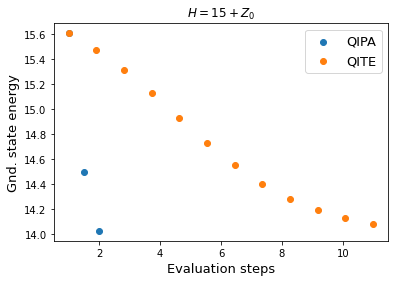

In [13]:
plt.scatter(np.linspace(1,kq,kq+1),Energy_qipa,label="QIPA")
plt.scatter(np.linspace(1,k,k+1),Energy_qite,label="QITE")
plt.xlabel("Evaluation steps",fontsize=13)
plt.ylabel("Gnd. state energy",fontsize=13)
#plt.grid(True)
plt.legend(loc='upper right',prop={'size': 13})
plt.title(r"$H=15+Z_0$",fontsize=12)
plt.show()

### Two-qubit test case

In [16]:
n_qub = 2 # number of qubit

Block0 = tq.gates.H(target=n_qub) + tq.gates.X(target=n_qub)
Block1 = tq.gates.Ry(target=0, angle=tq.Variable(name="th_0")) 
Block1 += tq.gates.Ry(target=1, angle=tq.Variable(name="th_1"))
Block2 = tq.gates.Rz(target=0, angle=tq.Variable(name="th_2"))
Block2 += tq.gates.Rz(target=1, angle=tq.Variable(name="th_3"))
Block3 = tq.gates.X(control=0, target=1)
Block4 = tq.gates.Ry(target=0, angle=tq.Variable(name="th_4"))
Block4 += tq.gates.Ry(target=1, angle=tq.Variable(name="th_5"))
Block5 = tq.gates.Rz(target=0, angle=tq.Variable(name="th_6"))
Block5 += tq.gates.Rz(target=1, angle=tq.Variable(name="th_7"))

Block6 = tq.gates.Ry(target=0, angle=tq.Variable(name="th_8")) 
Block6 += tq.gates.Ry(target=1, angle=tq.Variable(name="th_9"))
Block7 = tq.gates.Rz(target=0, angle=tq.Variable(name="th_10"))
Block7 += tq.gates.Rz(target=1, angle=tq.Variable(name="th_11"))
Block8 = tq.gates.X(control=0, target=1)
Block9 = tq.gates.Ry(target=0, angle=tq.Variable(name="th_12"))
Block9 += tq.gates.Ry(target=1, angle=tq.Variable(name="th_13"))
Block10 = tq.gates.Rz(target=0, angle=tq.Variable(name="th_14"))
Block10 += tq.gates.Rz(target=1, angle=tq.Variable(name="th_15"))


def testham2():
    ham = 10- Z(0)*Z(1)
    return ham

def ansatz_test2():
    U = tq.QCircuit()
    U += Block1 + Block2 + Block3 + Block4 + Block5
    return U

def ansatz_test2_qipa():
    U = tq.QCircuit()
    U += Block6 + Block7 + Block8 + Block9 + Block10
    return U

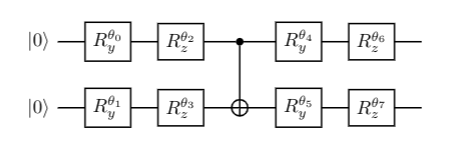

In [31]:
# two-qubit ansatz

from IPython.display import Image

Image(filename=('two_qubit_ansatz.png'))

In [22]:
# QIPA with test Hamiltonian and ansatz circuit

def Y_ctrl(i):
    YC = tq.gates.Trotterized(generator=1-Y(i),angle=np.pi,target=i,control=n_qub)
    return YC

def Z_ctrl(i):
    ZC = tq.gates.Trotterized(generator=1-Z(i),angle=np.pi,target=i,control=n_qub)
    return ZC

def A_element_matrix(i,j,qipa_stat):
    A = []
    if (i<j):
        if (qipa_stat == False):
            if (i<n_qub) and (j<n_qub):
                A = Block0 + Y_ctrl(i) + tq.gates.X(target=n_qub) + Y_ctrl(j)
                A += Block1 + Block2 + Block3 + Block4 + Block5
            if (i<n_qub) and (j<(2*n_qub) and j>(n_qub-1)):
                A = Block0 + Y_ctrl(i) + tq.gates.X(target=n_qub) + Block1
                A += Z_ctrl(j%n_qub) + Block2 + Block3 + Block4 + Block5
            if (i<n_qub) and (j<(3*n_qub) and j>(2*n_qub-1)):
                A = Block0 + Y_ctrl(i) + tq.gates.X(target=n_qub) + Block1 
                A += Block2 + Block3 + Y_ctrl(j%n_qub) + Block4 + Block5
            if (i<n_qub) and (j<(4*n_qub) and j>(3*n_qub-1)):
                A = Block0 + Y_ctrl(i) + tq.gates.X(target=n_qub) + Block1 
                A += Block2 + Block3 + Block4 + Z_ctrl(j%n_qub) + Block5    
            if (i<(2*n_qub) and i>(n_qub-1)) and (j<(2*n_qub) and j>(n_qub-1)):
                A = Block0 + Block1 + Z_ctrl(i%n_qub) + tq.gates.X(target=n_qub)
                A += Z_ctrl(j%n_qub) + Block2 + Block3 + Block4 + Block5 
            if (i<(2*n_qub) and i>(n_qub-1)) and (j<(3*n_qub) and j>(2*n_qub-1)):
                A = Block0 + Block1 + Z_ctrl(i%n_qub) + tq.gates.X(target=n_qub) + Block2
                A += Block3 + Y_ctrl(j%n_qub) + Block4 + Block5
            if (i<(2*n_qub) and i>(n_qub-1)) and (j<(4*n_qub) and j>(3*n_qub-1)):
                A = Block0 + Block1 + Z_ctrl(i%n_qub) + tq.gates.X(target=n_qub) + Block2
                A += Block3 + Block4 + Z_ctrl(j%n_qub) + Block5
            if (i<(3*n_qub) and i>(2*n_qub-1)) and (j<(3*n_qub) and j>(2*n_qub-1)):
                A = Block0 + Block1 + Block2 + Block3 + Y_ctrl(i%n_qub) 
                A += tq.gates.X(target=n_qub) + Y_ctrl(j%n_qub) + Block4 + Block5
            if (i<(3*n_qub) and i>(2*n_qub-1)) and (j<(4*n_qub) and j>(3*n_qub-1)):
                A = Block0 + Block1 + Block2 + Block3 + Y_ctrl(i%n_qub) 
                A += tq.gates.X(target=n_qub) + Block4 + Z_ctrl(j%n_qub) + Block5
            if (i<(4*n_qub) and i>(3*n_qub-1)) and (j<(4*n_qub) and j>(3*n_qub-1)):
                A = Block0 + Block1 + Block2 + Block3 + Block4 + Z_ctrl(i%n_qub) 
                A += tq.gates.X(target=n_qub) + Z_ctrl(j%n_qub) + Block5
        else:
            if (i<n_qub) and (j<n_qub):
                A = Block0 + Y_ctrl(i) + tq.gates.X(target=n_qub) + Y_ctrl(j)
                A += Block6 + Block7 + Block8 + Block9 + Block10
            if (i<n_qub) and (j<(2*n_qub) and j>(n_qub-1)):
                A = Block0 + Y_ctrl(i) + tq.gates.X(target=n_qub) + Block6
                A += Z_ctrl(j%n_qub) + Block7 + Block8 + Block9 + Block10
            if (i<n_qub) and (j<(3*n_qub) and j>(2*n_qub-1)):
                A = Block0 + Y_ctrl(i) + tq.gates.X(target=n_qub) + Block6 
                A += Block7 + Block8 + Y_ctrl(j%n_qub) + Block9 + Block10
            if (i<n_qub) and (j<(4*n_qub) and j>(3*n_qub-1)):
                A = Block0 + Y_ctrl(i) + tq.gates.X(target=n_qub) + Block6 
                A += Block7 + Block8 + Block9 + Z_ctrl(j%n_qub) + Block10    
            if (i<(2*n_qub) and i>(n_qub-1)) and (j<(2*n_qub) and j>(n_qub-1)):
                A = Block0 + Block6 + Z_ctrl(i%n_qub) + tq.gates.X(target=n_qub)
                A += Z_ctrl(j%n_qub) + Block7 + Block8 + Block9 + Block10 
            if (i<(2*n_qub) and i>(n_qub-1)) and (j<(3*n_qub) and j>(2*n_qub-1)):
                A = Block0 + Block6 + Z_ctrl(i%n_qub) + tq.gates.X(target=n_qub) + Block7
                A += Block8 + Y_ctrl(j%n_qub) + Block9 + Block10
            if (i<(2*n_qub) and i>(n_qub-1)) and (j<(4*n_qub) and j>(3*n_qub-1)):
                A = Block0 + Block6 + Z_ctrl(i%n_qub) + tq.gates.X(target=n_qub) + Block7
                A += Block8 + Block9 + Z_ctrl(j%n_qub) + Block10
            if (i<(3*n_qub) and i>(2*n_qub-1)) and (j<(3*n_qub) and j>(2*n_qub-1)):
                A = Block0 + Block6 + Block7 + Block8 + Y_ctrl(i%n_qub) 
                A += tq.gates.X(target=n_qub) + Y_ctrl(j%n_qub) + Block9 + Block10
            if (i<(3*n_qub) and i>(2*n_qub-1)) and (j<(4*n_qub) and j>(3*n_qub-1)):
                A = Block0 + Block6 + Block7 + Block8 + Y_ctrl(i%n_qub) 
                A += tq.gates.X(target=n_qub) + Block9 + Z_ctrl(j%n_qub) + Block10
            if (i<(4*n_qub) and i>(3*n_qub-1)) and (j<(4*n_qub) and j>(3*n_qub-1)):
                A = Block0 + Block6 + Block7 + Block8 + Block9 + Z_ctrl(i%n_qub) 
                A += tq.gates.X(target=n_qub) + Z_ctrl(j%n_qub) + Block10
    return A

def delta_step(var_values):
    # Constructing the matrix A

    f = 0.25 # (f^*_{ki}.f_{lj})
    A_matrix = np.zeros((len(var_values),len(var_values)))
    for i in range(len(A_matrix)):
        for j in range(len(A_matrix)):
            if (i<j):
                E = tq.ExpectationValue(H=X(n_qub), U=A_element_matrix(i,j,qipa_stat=False))
                A_matrix[i][j] += np.real(f*tq.simulate(E, variables=var_values))
            elif (i>j):
                A_matrix[i][j] += A_matrix[j][i]
            else:
                A_matrix[i][j] += 0.25
    
    # Constructing the vector C

    kappa = 1 # 1 for imaginary time, >1 for QIPA
    fC = 1j/2
    C_vec = np.zeros((len(var_values),1))
    for i in range(len(C_vec)):
        E = tq.ExpectationValue(H=Ham, U=total_U)
        dE = tq.grad(E,"th_"+str(i))
        C_vec[i] += np.real(0.5*kappa*tq.simulate(dE, variables=var_values))
    
    # invoking conjugate gradient method rather than explictly inverting a matrix
    output = s_linalg.cg(A_matrix,C_vec,tol=1e-4)
    return -1.0*output[0]

def delta_step_qipa(b,tau,var_values):
    # Constructing the matrix A

    f = 0.25 # (f^*_{ki}.f_{lj})
    A_matrix = np.zeros((len(var_values),len(var_values)))
    for i in range(len(A_matrix)):
        for j in range(len(A_matrix)):
            if (i<j):
                E = tq.ExpectationValue(H=X(n_qub), U=A_element_matrix(i,j,qipa_stat=True))
                A_matrix[i][j] += np.real(f*tq.simulate(E, variables=var_values))
            elif (i>j):
                A_matrix[i][j] += A_matrix[j][i]
            else:
                A_matrix[i][j] += 0.25
    
    # Constructing the vector C

    kappa = b # 1 for imaginary time
    fC = 1j/2
    C_vec = np.zeros((len(var_values),1)) 
    Ham = testham2()
    Ham_mod = Ham + (b*tau*Ham*Ham) + 0.5*b*b*tau*tau*(Ham**3)
    for i in range(len(C_vec)):
        E = tq.ExpectationValue(H=Ham_mod, U=ansatz_test3_qipa())
        dE = tq.grad(E,"th_"+str(i+len(C_vec)))
        C_vec[i] += np.real(0.5*kappa*tq.simulate(dE, variables=var_values))
    
    # invoking conjugate gradient method rather than explictly inverting a matrix
    output = s_linalg.cg(A_matrix,C_vec,tol=1e-4)
    return -1.0*output[0]

In [39]:
# QITE subroutine

# Random initialization of variables at t=0
pqc_var_values = {key: random.uniform(0, np.pi) for key in variables} # single qubit ansatz
# Copying the dictionary to another dict. with different keys
Obj_ext = tq.ExpectationValue(H=testham2(), U=ansatz_test2_qipa())
variables_ext = Obj_ext.extract_variables()
#variables_ext = sorted(variables_ext, key=lambda x: x.name)
cnt = 0
temp_values = np.zeros(len(pqc_var_values))
for key,value in pqc_var_values.items():
    temp_values[cnt] = value
    cnt +=1
cnt = 0
stored_values = dict(zip(variables_ext, [None]*len(variables_ext)))
for k in stored_values:
    stored_values[k] = temp_values[cnt]
    cnt += 1
        
E = tq.ExpectationValue(H=testham2(), U=ansatz_test2())
res = tq.simulate(E, variables=pqc_var_values)

Energy_qite2 = np.array([])
Energy_qite2 = np.append(Energy_qite2,res)
print(res)

# time step duration
deltaT = 0.1

# exact diagonalizing energy
res_ex = Htrans_exact(testham2())

# Looping over some number of times till accuracy is reached
k2 = 0
print(pqc_var_values)
while (res-res_ex > 1e-1):
    delta_step_var_values = delta_step(pqc_var_values)*deltaT
    cnt = 0
    for key in variables:
        pqc_var_values[key] += delta_step_var_values[cnt].item()
        cnt += 1
    
    E = tq.ExpectationValue(H=testham2(), U=ansatz_test2())
    res = tq.simulate(E, variables=pqc_var_values)
    Energy_qite2 = np.append(Energy_qite2,res)
    print(res)
    print(pqc_var_values)
    print("Done:",k2)
    k2 += 1

10.523396384150933
{th_0: 0.6081886393966449, th_1: 0.4045433858749125, th_2: 1.7045694073706583, th_3: 0.5386392413946118, th_4: 0.14453819195452527, th_5: 1.8424252605746467, th_6: 2.9075115654479653, th_7: 0.7918716096516859}
10.370687244851906
{th_0: 0.6403274905085812, th_1: 0.4313660302250808, th_2: 1.6790394641611885, th_3: 0.5707341476288814, th_4: 0.16217318166166328, th_5: 1.661328413476683, th_6: 2.9314781093883155, th_7: 0.7946589600823796}
Done: 0
10.19226310104957
{th_0: 0.6775575587034782, th_1: 0.4466362393931858, th_2: 1.6514453560474476, th_3: 0.6086777517277341, th_4: 0.17751153461223104, th_5: 1.4754304557857032, th_6: 2.9555909895634427, th_7: 0.7971652520258161}
Done: 1
9.996967973757792
{th_0: 0.7184271409245393, th_1: 0.4478145445551023, th_2: 1.6236168671278557, th_3: 0.6508041476187886, th_4: 0.18858110644530596, th_5: 1.2902734860328224, th_6: 2.9783128816048094, th_7: 0.7993783086180621}
Done: 2
9.79852474644059
{th_0: 0.7606423578485351, th_1: 0.43409268252

In [40]:
#QIPA subroutine

# Same initial angles as QITE subroutine for comparison
E = tq.ExpectationValue(H=testham2(), U=ansatz_test2_qipa())
res = tq.simulate(E, variables=stored_values)
Energy_qipa2 = np.array([])
Energy_qipa2 = np.append(Energy_qipa2,res)
print(res)

# time step duration
deltaT = 0.1
b = 1 # temperature term, beta in QITE

# exact diagonalizing energy
res_ex = Htrans_exact(testham2())

# Looping over some number of times till accuracy is reached
kq2 = 0
print(stored_values)
while (res-res_ex > 1e-1):
    delta_step_var_values_qipa = delta_step_qipa(1,deltaT,stored_values)*deltaT
    cnt = 0
    for key in variables_ext:
        stored_values[key] += delta_step_var_values_qipa[cnt].item()
        cnt += 1
    
    E = tq.ExpectationValue(H=testham2(), U=ansatz_test2_qipa())
    res = tq.simulate(E, variables=stored_values)
    Energy_qipa2 = np.append(Energy_qipa2,res)
    print(res)
    print(stored_values)
    print("Done:",kq2)
    kq2 += 1

10.523396384150931
{th_8: 0.6081886393966449, th_9: 0.4045433858749125, th_10: 1.7045694073706583, th_11: 0.5386392413946118, th_12: 0.14453819195452527, th_13: 1.8424252605746467, th_14: 2.9075115654479653, th_15: 0.7918716096516859}
9.777560351076211
{th_8: 0.7529742272618856, th_9: 0.5253781198361904, th_10: 1.5895586129259027, th_11: 0.6832271605299043, th_12: 0.22398324919167617, th_13: 1.0265851688830323, th_14: 3.0154790453345233, th_15: 0.8044289132268567}
Done: 0
9.12038633505922
{th_8: 0.9683152230110255, th_9: 0.3556791628427295, th_10: 1.4837555415154189, th_11: 0.9055253521524221, th_12: 0.2117001475694567, th_13: 0.3261025426240898, th_14: 3.0856746483185082, th_15: 0.8109804900165938}
Done: 1
9.003587523088127
{th_8: 1.0519194934393943, th_9: 0.080262878172561, th_10: 1.469271136601315, th_11: 0.9885484503951201, th_12: 0.06138333772686949, th_13: 0.04956350392174008, th_14: 3.083644338395012, th_15: 0.8131784284148702}
Done: 2


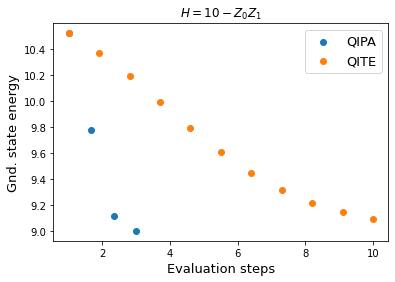

In [41]:
plt.scatter(np.linspace(1,kq2,kq2+1),Energy_qipa2,label="QIPA")
plt.scatter(np.linspace(1,k2,k2+1),Energy_qite2,label="QITE")
plt.xlabel("Evaluation steps",fontsize=13)
plt.ylabel("Gnd. state energy",fontsize=13)
#plt.grid(True)
plt.legend(loc='upper right',prop={'size': 13})
plt.title(r"$H=10-Z_0 Z_1$",fontsize=12)
plt.show()